# Nonlocality Optimization in the Bilocal Scenario

This notebook considers the bilocal Bell inequalities described in  [https://arxiv.org/abs/1112.4502](https://arxiv.org/abs/1112.4502).
These inequalities pertain to a simple tripartite network known as the bilocal scenario:

![](images/bilocal_scenario.png)

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Binary Inputs and Outputs

Consider a bilocal scenario with inputs and outputs $x,y,z,a,b,c\in\{0,1\}$.
The correlator is then defined as

$$
\langle A_x B_y C_z \rangle_{P_{22}} := \sum_{a,b,c}(-1)^{a+b+c}P_{22}(a,b,c|x,y,x).
$$

The following linear combinations will be useful:

$$
I_{22} := \frac{1}{4}\sum_{x,z\in\{0,1\}}\langle A_x B_0 C_z\rangle_{P_{22}}, \quad \text{and}
$$

$$
J_{22} := \frac{1}{4}\sum_{x,z\in\{0,1\}}(-1)^{x+z}\langle A_x B_1 C_z\rangle_{P_{22}}.
$$

The non-linear bi-local Bell inequality is then expressed as $\sqrt{|I_{22}|} + \sqrt{|J_{22}|} \leq 1.$

In [93]:
# The bilocal scenario requires 4 qubits ["a","b0","b1",c]
dev = qml.device("default.qubit", wires=["a","b0","b1","c"])

# optimizer
opt = qml.GradientDescentOptimizer()

@qml.qnode(dev)
def real_bilocal_measurement_circuit(a_measurement, b_measurement, c_measurement):  
    """
    Ansatz circuit where maximally entangled bipartite states are prepared and
    measurents are free to rotate about the y-axis.
    In this model, all quantum states real.
    This scenario considers binary inputs and outputs for all parties.

    Args:
        a_measurement (float) : 1 rotation angle of Alice's measurement
        b_measurement (array[float]) : 2 rotation angles of Bob's 2-qubit measurement 
        c_measurement (float) : 1 rotation angle of Charlie's measurement
    """
    # prepare entanglement between Alice and Bob
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b0"])
    
    # prepare entanglement between Bob and Charlie
    qml.Hadamard(wires="c")
    qml.CNOT(wires=["c","b1"])
    
    # single qubit measurement for Alice and Charlie
    qml.RY(a_measurement, wires="a")
    qml.RY(c_measurement, wires="c")
    
    # 2-qubit measurement for Bob
    qml.RY(b_measurement[0], wires="b0")
    qml.RY(b_measurement[1], wires="b1")

    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b0") @ qml.PauliZ("b1") @ qml.PauliZ("c"))

@qml.qnode(dev)
def bilocal22_circuit(ab_state, bc_state, a_measurement, b_measurement, c_measurement):
    """
    Ansatz circuit where maximally entangled bipartite states are prepared and
    measurents are free to rotate about the y-axis.
    In this model, all quantum states real.
    This scenario considers binary inputs and outputs for all parties.

    Args:
        ab_state (array[float]) : 15 rotation angles for the 2-qubit entangled state for alice and bob
        bc_state (array[float]) : 15 rotation angles for the 2-qubit entangled state for alice and charlie
        a_measurement (array[float]) : 3 rotation angls of Alice's measurement
        b_measurement (array[float]) : 15 rotation angles of Bob's 2-qubit measurement 
        c_measurement (array[float]) : 3 rotation angles of Charlie's measurement
    """
    
    qml.templates.subroutines.ArbitraryUnitary(ab_state, ["a","b0"])
    qml.templates.subroutines.ArbitraryUnitary(bc_state, ["b1","c"])
    
    qml.templates.subroutines.ArbitraryUnitary(a_measurement, ["a"])
    qml.templates.subroutines.ArbitraryUnitary(b_measurement, ["b0","b1"])
    qml.templates.subroutines.ArbitraryUnitary(c_measurement, ["c"])

    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b0") @ qml.PauliZ("b1") @ qml.PauliZ("c"))

In [89]:
def real_bilocal_measurement_settings():
    """
    Returns an array containing randomized tensors containing input values for
    `real_bilocal_measurement_circuit()`.
    """
    return [
        2*np.pi*np.random.random((2, 1)) - np.pi,
        2*np.pi*np.random.random((2, 2)) - np.pi,
        2*np.pi*np.random.random((2, 1)) - np.pi
    ]

def bilocal22_settings():
    """
    Returns an array containing randomized tensors containing input values for
    `bilocal22_circuit()`.
    """
    return [
        2*np.pi*np.random.random((1, 15)) - np.pi,
        2*np.pi*np.random.random((1, 15)) - np.pi,
        2*np.pi*np.random.random((2, 3)) - np.pi,
        2*np.pi*np.random.random((2, 15)) - np.pi,
        2*np.pi*np.random.random((2, 3)) - np.pi
    ]

In [91]:
def real_bilocal_measurement_cost(settings):
    """
    Applies the bilocality inequality as a cost function with respect to the `real_bilocal_measurement_circuit()`.
    """
    I22_run1 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0]
    )
    I22_run2 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][0],
        settings[2][0]
    )
    I22_run3 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1]
    )
    I22_run4 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][0],
        settings[2][1]
    ) 
    I22 = (I22_run1 + I22_run2 + I22_run3 + I22_run4)/4
    
    J22_run1 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][1],
        settings[2][0]
    )
    J22_run2 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][1],
        settings[2][0]
    )
    J22_run3 = real_bilocal_measurement_circuit(
        settings[0][0],
        settings[1][1],
        settings[2][1]
    )
    J22_run4 = real_bilocal_measurement_circuit(
        settings[0][1],
        settings[1][1],
        settings[2][1]
    )
    J22 = (J22_run1 - J22_run2 - J22_run3 + J22_run4)/4

    return -1*(np.sqrt(abs(I22)) + np.sqrt(abs(J22)))

def bilocal22_cost(settings):
    """
    Applies the bilocality inequality as a cost function with respect to the `bilocal22_circuit()`.
    """
    I22_run1 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][0],
        settings[4][0]
    )
    I22_run2 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][0],
        settings[4][0]
    )
    I22_run3 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][0],
        settings[4][1]
    )
    I22_run4 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][0],
        settings[4][1]
    ) 
    I22 = (I22_run1 + I22_run2 + I22_run3 + I22_run4)/4
    
    J22_run1 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][1],
        settings[4][0]
    )
    J22_run2 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][1],
        settings[4][0]
    )
    J22_run3 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][0],
        settings[3][1],
        settings[4][1]
    )
    J22_run4 = bilocal22_circuit(
        settings[0][0],
        settings[1][0],
        settings[2][1],
        settings[3][1],
        settings[4][1]
    )
    J22 = (J22_run1 - J22_run2 - J22_run3 + J22_run4)/4

    return -1*(np.sqrt(abs(I22)) + np.sqrt(abs(J22)))

In [58]:
# initial settings
real_settings = real_bilocal_measurement_settings()
real_scores = []

# performing gradient descent
for i in range(500):
    real_settings = opt.step(real_bilocal_measurement_cost, real_settings)
    score = -(real_bilocal_measurement_cost(real_settings))
    real_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", real_settings, "\n")

# printing final results    
print("final score : ", score,",")
print("final settings : ", real_settings)

iteration :  0 , score :  0.8268111820431274
settings :
 [array([[3.10751155],
       [0.1738026 ]]), array([[ 1.48011669, -2.3436165 ],
       [ 2.2049385 , -1.74057809]]), array([[-1.3436567],
       [ 0.7321358]])] 

iteration :  50 , score :  1.0648986697836451
settings :
 [array([[2.86540287],
       [0.20048133]]), array([[ 1.48517322, -2.4315457 ],
       [ 2.41531191, -1.75921244]]), array([[-1.29977749],
       [ 0.79482015]])] 

iteration :  100 , score :  1.185680006568105
settings :
 [array([[2.70098453],
       [0.22735597]]), array([[ 1.48587251, -2.52380626],
       [ 2.55215633, -1.76636418]]), array([[-1.24582078],
       [ 0.84027574]])] 

iteration :  150 , score :  1.2570175048648569
settings :
 [array([[2.58076108],
       [0.25821481]]), array([[ 1.48182137, -2.61022074],
       [ 2.64557207, -1.76351929]]), array([[-1.1898956 ],
       [ 0.86792015]])] 

iteration :  200 , score :  1.3029951240695794
settings :
 [array([[2.49038657],
       [0.29107182]]), array(

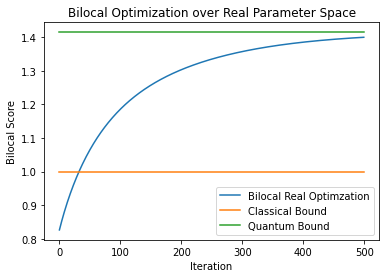

In [59]:
# Plot the score of the Bell inequality
plt.plot(range(500), real_scores , label = "Bilocal Real Optimzation")
plt.plot(range(500), [1]*500, label = "Classical Bound")
plt.plot(range(500), [2*np.sqrt(1/2)]*500, label = "Quantum Bound")
plt.title("Bilocal Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("Bilocal Score")
plt.legend()
plt.show()

In [95]:
# initial settings
arb_settings = bilocal22_settings()
arb_scores = []

# performing gradient descent
for i in range(1000):
    arb_settings = opt.step(bilocal22_cost, arb_settings)
    score = -(bilocal22_cost(arb_settings))
    arb_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", arb_settings, "\n")

# printing final results    
print("final score : ", score,",")
print("final settings : ", arb_settings)

iteration :  0 , score :  0.5098606443508823
settings :
 [array([[ 1.15319411, -0.68965035,  0.15484382, -0.33601834, -0.66828219,
         1.69401659,  1.51161829, -0.82109254,  0.60380296, -2.75389479,
         1.86784715,  2.98948369, -1.05510505, -3.1195901 ,  1.12084261]]), array([[ 2.74741374,  2.98170199,  0.11825203,  0.45244335, -3.12629308,
        -2.64617727, -1.09328155,  1.41317494, -1.63165122, -0.54261434,
        -0.99073144,  2.9647564 ,  1.76499827,  2.78505986,  0.63068025]]), array([[ 0.49637146,  2.37513738, -0.60462702],
       [-1.83492294, -0.33245171,  3.08017418]]), array([[-0.80390696, -0.61401243, -0.19583757, -2.31058759,  0.53856814,
         1.22192433,  0.41254627, -1.33938105, -2.46009049,  2.18783871,
         0.75911396, -2.31117719,  2.00898993, -1.08447595, -1.43788914],
       [-2.46758411, -2.55973483,  1.12147572, -1.96443758,  1.80032088,
         3.07435246, -2.71973323,  1.43914292,  1.67556079, -2.30777852,
        -1.72485909, -1.24953724, 

iteration :  400 , score :  1.255123816031965
settings :
 [array([[ 1.1128656 , -0.67481465,  0.1538752 , -0.60848883, -0.8959686 ,
         1.79735346,  1.49166344, -0.65309112,  0.55929332, -2.86520336,
         1.83206342,  2.91229562, -1.34863922, -3.15193636,  1.26685715]]), array([[ 2.36425757,  2.91676915,  0.15080267,  0.07139509, -3.47326513,
        -2.50879686, -1.05649777,  1.51163186, -1.66084102, -0.47852639,
        -1.25838658,  3.02989807,  1.68886791,  2.65755567,  0.59938839]]), array([[ 0.52631216,  2.28275717, -0.60462702],
       [-1.81771961, -0.4586701 ,  3.08017418]]), array([[-0.74529652, -0.5310131 , -0.03189542, -2.58204098,  0.55299447,
         1.26721107,  0.14334855, -1.35759111, -2.22897969,  2.20714297,
         0.7299336 , -2.32488453,  1.87805475, -1.08447595, -1.43788914],
       [-2.4944294 , -2.62952294,  1.12687943, -1.91793854,  1.70103594,
         3.07509233, -2.66473033,  1.41639983,  1.61055479, -2.31459181,
        -1.73416349, -1.22675562,

iteration :  800 , score :  1.388046616065752
settings :
 [array([[ 1.10373881, -0.6704915 ,  0.15492383, -0.65379604, -0.88903547,
         1.80284041,  1.49356359, -0.61015939,  0.56308949, -2.85839796,
         1.81173952,  2.93379606, -1.37604801, -3.17132017,  1.2501874 ]]), array([[ 1.94859485,  2.91179108,  0.24501076,  0.0159008 , -3.62247322,
        -2.65929285, -1.13627457,  1.57450916, -1.83409783, -0.58151444,
        -1.30678463,  2.99049916,  1.6307917 ,  2.54206446,  0.55001962]]), array([[ 0.51076425,  2.25070818, -0.60462702],
       [-1.81044955, -0.47833505,  3.08017418]]), array([[-0.74295184, -0.52712929, -0.02412626, -2.77661732,  0.3960165 ,
         1.29816175,  0.05066729, -1.39965984, -2.08913656,  2.2009658 ,
         0.74311085, -2.31519432,  1.65040849, -1.08447595, -1.43788914],
       [-2.50331895, -2.65190328,  1.11001402, -1.87800088,  1.81254238,
         3.09312748, -2.63983657,  1.42334619,  1.61110869, -2.27172242,
        -1.65181999, -1.30090925,

In [2]:
# Plot the score of the Bell inequality
plt.plot(range(1000), arb_scores , label = r"Gradient Ascent")
plt.plot(range(1000), [1]*1000, label = "Classical Bound")
plt.plot(range(1000), [2*np.sqrt(1/2)]*1000, label = "Quantum Bound")
plt.title("Gradient Ascent Optimization \n of Bilocal Nonlocality")

plt.xlabel("Gradient Ascent Iteration")
plt.ylabel(r"Bilocal Bell Score")
plt.legend()
plt.show()

NameError: name 'arb_scores' is not defined

## Bob has a 1 Input and 4 Outputs

This scenario represents the case where Bob performs a complete Bell measurement on the two-qubit states.
The correlator is defined:

$$
\langle A_x B^y C_z \rangle_{P_{14}} := \sum_{a,b^0 b^1,c}(-1)^{a+b^y+c}P_{14}(a,b^0 b^1,c|x,z)
$$

The following linear combinations simplify the Bell inequality:

$$
I_{14} := \frac{1}{4}\sum_{x,z\in 0,1}\langle A_x B^0 C_z\rangle_{P_{14}}, \quad \text{and}
$$

$$
J_{14} := \frac{1}{4}\sum_{x,z \in 0,1}(-1)^{x+z}\langle A_x B^1 C_z \rangle_{P_{14}}.
$$

The Bilocal Bell inequality is then expressed as $\sqrt{|I_{14}|} + \sqrt{|J_{14}|} \leq 1.$


In [116]:
# The bi-local scenario requires 4 qubits ["a","b0","b1",c]
dev = qml.device("default.qubit", wires=["a","b0","b1","c"])

# optimizer
opt = qml.GradientDescentOptimizer()

@qml.qnode(dev)
def real_bilocal14_measurement_circuit(a_measurement, b_measurement, c_measurement):  
    """
    Ansatz circuit where maximally entangled bipartite states are prepared and
    measurents are free to rotate about the y-axis.
    In this model, all quantum states real.
    This scenario considers binary inputs and outputs for all parties.

    Args:
        a_measurement (float) : 1 rotation angle of Alice's measurement
        c_measurement (float) : 1 rotation angle of Charlie's measurement
    """
    # prepare entanglement between Alice and Bob
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b0"])
    
    # prepare entanglement between Bob and Charlie
    qml.Hadamard(wires="c")
    qml.CNOT(wires=["c","b1"])
    
    # single qubit measurement for Alice and Charlie
    qml.RY(a_measurement, wires="a")
    qml.RY(c_measurement, wires="c")
    
    # 2-qubit measurement for Bob
    qml.templates.subroutines.ArbitraryUnitary(b_measurement, ["b0","b1"])
    
    return qml.probs(wires=["a","b0","b1","c"])

#     return [qml.expval(qml.PauliZ("a")), qml.expval(qml.PauliZ("b0") @ qml.PauliZ("b1")),  qml.expval(qml.PauliZ("c"))]



In [98]:
def real_bilocal14_measurement_settings():
    """
    Returns an array containing randomized tensors containing input values for
    `real_bilocal_measurement_circuit()`.
    """
    return [
        2*np.pi*np.random.random((2, 1)) - np.pi,
        2*np.pi*np.random.random((1, 15)) - np.pi,
        2*np.pi*np.random.random((2, 1)) - np.pi
    ]

In [118]:
settings = real_bilocal14_measurement_settings()
probs = real_bilocal14_measurement_circuit(settings[0][0], settings[1][0], settings[2][0])
probs

tensor([0.03018769, 0.0917091 , 0.11128203, 0.02823888, 0.04117757,
        0.0954323 , 0.06735271, 0.03461971, 0.03174455, 0.09635866,
        0.03943764, 0.07104145, 0.08768767, 0.02570246, 0.09113014,
        0.05689744], requires_grad=True)

In [120]:
reshaped_probs = np.reshape(probs,(2,2,2,2))
reshaped_probs      

tensor([[[[0.03018769, 0.0917091 ],
          [0.11128203, 0.02823888]],

         [[0.04117757, 0.0954323 ],
          [0.06735271, 0.03461971]]],


        [[[0.03174455, 0.09635866],
          [0.03943764, 0.07104145]],

         [[0.08768767, 0.02570246],
          [0.09113014, 0.05689744]]]], requires_grad=True)